<h1><center><font size="6">Classification</font></center></h1>



In your second homework you need to create a model that predicts which passengers survived the Titanic shipwreck.

In [185]:
import pandas as pd
import numpy as np
import datetime
import sys
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics

In [186]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

# <a id='3'>Data exploration</a>  

We check the shape of train and test dataframes and also show a selection of rows, to have an initial understanding of the data.



In [187]:
train_df.sample(5).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.0,0,0,3101264,6.4958,NaN,S
554,555,1,3,"Ohman, Miss. Velin",female,22.0,0,0,347085,7.7750,NaN,S
401,402,0,3,"Adams, Mr. John",male,26.0,0,0,341826,8.0500,NaN,S
123,124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S


In [188]:
test_df.sample(5).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
219,1111,3,"Thomson, Mr. Alexander Morrison",male,NaN,0,0,32302,8.050,NaN,S
144,1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.0,0,0,17475,26.550,NaN,S
382,1274,3,"Risien, Mrs. Samuel (Emma)",female,NaN,0,0,364498,14.500,NaN,S
97,989,3,"Makinen, Mr. Kalle Edvard",male,29.0,0,0,STON/O 2. 3101268,7.925,NaN,S
196,1088,1,"Spedden, Master. Robert Douglas",male,6.0,0,2,16966,134.500,E34,C


In [189]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))
print("Test:  rows:{} cols:{}".format(test_df.shape[0], test_df.shape[1]))

Train: rows:891 cols:12
Test:  rows:418 cols:11


Both **train** and **test** files contains the following values:  

* **PassengerID** - the index of the passenger (in the dataset);  
* **PClass** - the class of the passenger (from 1 to 3);
* **Name** - the name of the passenger;
* **Sex** - the sex of the passenger (female or male);  
* **Age** - the age (where available) of the passenger;  
* **SibSp** - the number of sibilings / spouses aboard of Titanic;  
* **Parch** - the number of parents / children aboard of Titanic;  
* **Ticket** - the ticket number;  
* **Fare** - the passenger fare (ticket cost);  
* **Cabin** - the cabin number;  
* **Embarked** - the place of embarcation of the passenger (C = Cherbourg, Q = Queenstown, S = Southampton).  

The **train** data has as well the target value, **Survived**.

It is important to have a good understanding of the data before going to create a model. Therefore we will explore the features.

Let's start by checking if there are missing data and unlabeled data.

Next, analyze the dependencies of the target variable on various features, such as Age, Sex, and so on, using approaches similar to those in the first homework.

Draw conclusions about what affects whether the passenger survives, check the distribution of features in the train and test data. 

In [1]:
train_df.describe()

NameError: name 'train_df' is not defined

In [190]:
import seaborn as sns
import math

# Check how much fields are empty per column
column_fill_percentage = train_df.isnull().mean().round(4).mul(100).sort_values(ascending=False)
print("How much percent of each columns do have valid values?")
print(column_fill_percentage)

How much percent of each columns do have valid values?
Cabin          77.10
Age            19.87
Embarked        0.22
PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
dtype: float64


In [191]:
# How many people survived in total?
survival_rate = train_df['Survived'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print("How many people survived?")
print(survival_rate)

How many people survived?
Survived
0    61.6%
1    38.4%
Name: proportion, dtype: object


/var/folders/x5/7f0lfbm502v_dzg8xmhl5v5c0000gn/T/ipykernel_54518/1473187158.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels)


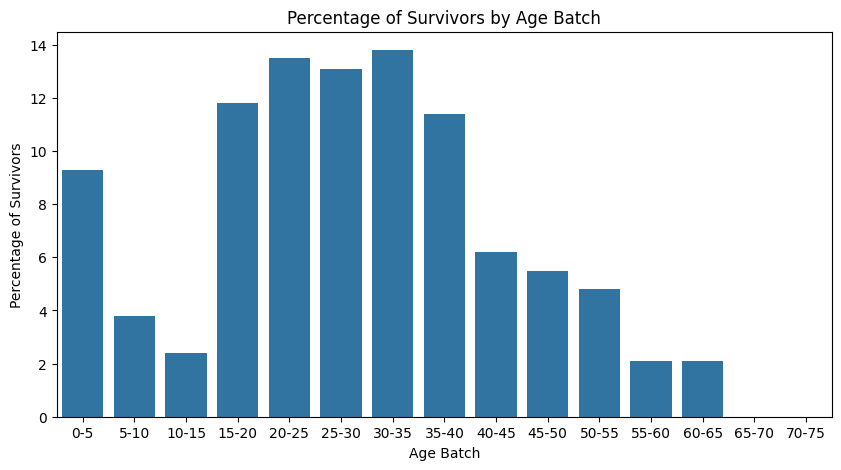

In [203]:
# Children vs Adults vs old people
def plot_survivorship_by_age_batches(file_path): # DO THIS BEFORE NORMALIZING THE AGES (filling empty values with median of all ages)
   df = pd.read_csv(file_path)

   # Round up the maximum age to the nearest whole number
   max_age = math.ceil(df['Age'].max())

   # Define bins for better visualisation
   bins = range(0, max_age, 5)
   bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
   df['Age Batch'] = pd.cut(df['Age'], bins=bins, right=False)

   df_survived = df[df['Survived'] == 1]

   # Convert the interval index to a regular index
   proportions = df_survived['Age Batch'].value_counts(normalize=True).mul(100).round(1)
   proportions.index = np.array([i.mid for i in proportions.index])

   # Create the bar plot
   plt.figure(figsize=(10, 5))
   ax = sns.barplot(x=proportions.index, y=proportions.values)
   ax.set_xticklabels(bin_labels)


   # Set the title and labels
   plt.title('Percentage of Survivors by Age Batch')
   plt.xlabel('Age Batch')
   plt.ylabel('Percentage of Survivors')

   # Display the plot
   plt.show()



plot_survivorship_by_age_batches("train.csv")

Apperantly people in the age range of 15-40 years were much more likely to survive. Also, babys and small children under 5 years where much more likely to survive.

In [193]:
### CLEAN UP DATA BEFORE RUNNING MODEL
# Let's check what we have to normalize/throw out
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [194]:
# What do we see above?
# 1) A lot of columns to drop (because irrelevant)
# 2) Sex is not numeric
# 3) Some ages are missing (= 'nan')

In [195]:
# Make sex numeric
train_df['Sex'].replace(['female','male'],[0,1], inplace=True)

# Remove non-numeric values (also apply common sense, e.g. the Cabin number can't be classified, as we don't have information on the location of cabins etc)
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis='columns')

# We know that age is null quite often. Let's fill it with the mean of ages.
train_df.Age.fillna(train_df.Age.mean(), inplace=True)
train_df.isnull().any().any()

# @KEITLIN: do this stuff in this box for test_df too

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    29.699118
6    54.000000
7     2.000000
8    27.000000
9    14.000000
Name: Age, dtype: float64

In [196]:
# Much better now:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.000000,1,0,7.2500
1,1,1,0,38.000000,1,0,71.2833
2,1,3,0,26.000000,0,0,7.9250
3,1,1,0,35.000000,1,0,53.1000
4,0,3,1,35.000000,0,0,8.0500
5,0,3,1,29.699118,0,0,8.4583
6,0,1,1,54.000000,0,0,51.8625
7,0,3,1,2.000000,3,1,21.0750
8,1,3,0,27.000000,0,2,11.1333
9,1,2,0,14.000000,1,0,30.0708


*Example:*
From the total female passengers, *n*% survived.  
In the same time, from the total male passengers, only m% survived.


## <a id='50'>Split the data</a>  

Let's split the training and validation set. We will use a 80-20 split. Don't forget to fix random_state. 


In [197]:
# NORMALIZE DATA BEFORE

# In decision tree classification we drop the labled output from the main datasaet and save it as a target (for preticting future value)
inputs = train_df[['Sex', 'Pclass']] # use only these, as it's required for the next task
target = train_df.Survived

# We split and set a random state, so that we get the same split every time we run this code
X_train, X_val, y_train, y_val = train_test_split(inputs, target, test_size=0.2, random_state=42)


## <a id='51'>Build a model</a>  

We will start with a simple model (baseline), with just two features, the `Sex` and `Pclass`. Create DesicionTreeClassifier and RandomForestClassifier, based on this features, without tuning parameters. 

Next, create two more complicated models: DesicionTreeClassifier and RandomForestClassifier with adding at least one feature you found useful as a result of your analysis.

Find accuracy score for all models. Is it a good idea to use accuracy? Any suggestions about metrics? 

Then try to tune at least one parameter for every model using grid search and write down features and parameters, which gave you best score. 

In [198]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()

In [199]:
# Train the model
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [200]:
# Check how good the model works (compare to test data, accuracy score)
print(f"The decision tree model score is: {decision_tree_model.score(X_val, y_val)}")
print(f"The random forest model score is: {random_forest_model.score(X_val, y_val)}")

The decision tree model score is: 0.7653631284916201
The random forest model score is: 0.7653631284916201


### Why (not) use accuracy:
Accuracy is a commonly used metric in machine learning to measure the performance of classification models. It calculates the proportion of correct predictions made by the model out of all predictions. However, accuracy can be misleading, particularly for imbalanced datasets where the majority class dominates the results. In such cases, a model that simply predicts the majority class will have high accuracy but is not useful for distinguishing between classes. Furthermore, accuracy does not account for the confidence of the predictions, which can be important in many applications. Therefore, while accuracy is a useful metric, it should not be the sole criterion for model evaluation. Other metrics such as precision, recall, F1 score, and area under the ROC curve (AUC-ROC) should also be considered to provide a more comprehensive understanding of model performance.

In [201]:
# NOW SECOND PART TRY, WITH NEW FEATURE:

# Let's use 'Age' as an additional parameter, as this cleary had an influence on survival rates
# In decision tree classification we drop the labled output from the main datasaet and save it as a target (for preticting future value)
inputs = train_df[['Sex', 'Pclass', 'Age']]
target = train_df.Survived

# We split and set a random state, so that we get the same split every time we run this code
X_train, X_val, y_train, y_val = train_test_split(inputs, target, test_size=0.2, random_state=42)

# Train the model
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Check how good the model works (compare to test data)
print(f"The decision tree model score is: {decision_tree_model.score(X_val, y_val)}")
print(f"The random forest model score is: {random_forest_model.score(X_val, y_val)}")

The decision tree model score is: 0.776536312849162
The random forest model score is: 0.7988826815642458


In [166]:
# Tune one parameter for each model using grid search.
from sklearn.model_selection import GridSearchCV

### Define the parameter values that should be searched
# For 'max_depth', a common practice is to start with a small value (like 1 or 2) and gradually increase it while monitoring the model's performance. If the model starts to overfit the training data (i.e., it performs well on the training data but poorly on unseen data), increasing the 'max_depth' can help prevent overfitting by making the model less complex.
param_grid_decision_tree = {'max_depth': np.arange(1, 10)}
# For 'n_estimators', a larger number generally leads to a more accurate model, as it allows the model to learn from more data. However, a larger number of estimators also increases the computational cost and the risk of overfitting. Therefore, it's often a trade-off between accuracy and computational efficiency.
param_grid_random_forest = {'n_estimators': np.arange(100, 500)}

# Instantiate the grid
grid_decision_tree = GridSearchCV(decision_tree_model, param_grid_decision_tree, cv=5)
grid_random_forest = GridSearchCV(random_forest_model, param_grid_random_forest, cv=5)

# Fit the grid with data
grid_decision_tree.fit(X_train, y_train)
grid_random_forest.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Decision Tree: ", grid_decision_tree.best_params_)
print("Best parameters for Random Forest: ", grid_random_forest.best_params_)

# THIS WILL TAKE TIME (~5 minutes!)
# We are searching over a range of 9 values for the 'max_depth' parameter
# of the DecisionTreeClassifier and 400 values for the 'n_estimators' parameter
# of the RandomForestClassifier. This means that the total number of 
# models trained is 9 * 400 = 3600 models. 
# Each of these models needs to be trained on your entire dataset, 
# which can take a significant amount of time, especially if your dataset is large.

Best parameters for Decision Tree:  {'max_depth': 5}
Best parameters for Random Forest:  {'n_estimators': 100}


In [172]:
from sklearn.metrics import accuracy_score

# Assuming gs_dtree and gs_rf are your GridSearchCV objects
best_decision_tree = grid_decision_tree.best_estimator_
best_random_forest = grid_random_forest.best_estimator_

# Check how good the model works (compare to test data)
print(f"The old decision tree model score is: {decision_tree_model.score(X_val, y_val)}")
print(f"The new decision tree model score is: {best_decision_tree.score(X_val, y_val)}")
print(f"The old random forest model score is: {random_forest_model.score(X_val, y_val)}")
print(f"The new random forest model score is: {best_random_forest.score(X_val, y_val)}")

The old decision tree model score is: 0.776536312849162
The new decision tree model score is: 0.7821229050279329
The old random forest model score is: 0.7988826815642458
The new random forest model score is: 0.7988826815642458


So above we can see that tuning the `max_depth` actually improved the accuracy, whereas there was no effect when tuning `n_estimators` for the random forest model. The latter is probably because 100 is the default value of the random_forest model, so explicitly setting it to 100 won't change anything.